In [1]:
import pandas as pd
import numpy as np
import spacy
import seaborn as sns
import pyLDAvis.gensim as gensimvis
import pyLDAvis
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
import pickle
from sklearn.manifold import TSNE
from termcolor import colored
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import text_to_word_sequence 
from sklearn.model_selection import train_test_split
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import regex as re

#!pip install pyLDAvis==2.1.2
#!python -m spacy download en_core_web_md

2023-05-02 12:32:19.186022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/nicolas/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/nicolas/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:169

# Data cleaning and preperation

## Loading keyword dataset

In [3]:
data_keywords = pd.read_csv("data/keywords.csv")

In [6]:
# missing keyword entries need to be replaced
data_keywords["keywords"].isna().sum()

0

In [7]:
# ~15.000 missing keyword entries
data_keywords["keywords"].value_counts()[:2]

[]                                            14795
[{'id': 187056, 'name': 'woman director'}]     1323
Name: keywords, dtype: int64

In [9]:
data_keywords["keywords_nan"] = data_keywords["keywords"].replace("[]", np.nan)

In [10]:
# keywords need to be parsed
data_keywords.iloc[[0]].keywords[0]

"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"

In [11]:
def key_word_grabber(text):
    """
    Function to retreive the keywords from the above string
    """
    if text is not np.nan:
        
        return re.findall(r"'name':\s*'([^']*)'", text)
    else:
        return text

In [13]:
data_keywords["keywords_list"] = data_keywords["keywords_nan"].apply(lambda x: key_word_grabber(x))

In [14]:
# now misssing keywords can easily be intentified
data_keywords["keywords_nan"].isna().sum()

14795

## Loading metadata dataset

In [15]:
metadata_df = pd.read_csv("data/movies_metadata.csv")

/Users/nicolas/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
# we are interested in the overview column. Preprocessing is necesarry

In [17]:
metadata_df["overview"].value_counts()[:5]

No overview found.                                            133
No Overview                                                     7
                                                                5
No movie overview available.                                    3
A few funny little novels about different aspects of life.      3
Name: overview, dtype: int64

In [18]:
metadata_df.drop(metadata_df.loc[metadata_df['overview']=="No movie overview available"].index, inplace=True)

In [19]:
def parse_overview(text):
    """
    Removing all overview descriptions with less than 20 characters
    """
    if text is not np.nan:
        
        if len(text) < 20:
            return np.nan
        else:
            return text

In [20]:
metadata_df["overview_filtered"] = metadata_df["overview"].apply(lambda x: parse_overview(x))

In [21]:
# removing rows with no overview description
metadata_df = metadata_df[metadata_df["overview_filtered"].notna()]

In [23]:
# merging metadata and keyword dataframes
metadata_df["id"] = metadata_df["id"].astype(int)
full_data = metadata_df.merge(data_keywords, on="id", how="left")

In [24]:
# remove lists from keyword entry
full_data["keywords_list"] = full_data["keywords_list"].apply(lambda x: " ".join(x) if x is not np.nan else x)

In [25]:
# turn Nan into empty string to avoid NaN after adding strings
full_data["keywords_list"] = full_data.keywords_list.fillna('')

In [26]:
# adding the 2 strings from overview description and keywords
full_data["overview_plus_keyword"] = full_data["overview_filtered"] + full_data["keywords_list"]

# spacy text processing

## text cleaning

In [27]:
nlp = spacy.load('en_core_web_md')

In [28]:
valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])
specific_stw = set(['relevant', 'simple', 'base'])

def text_preprocessing(rawtext):

    english_doc = nlp(rawtext)

    new_tokens = list()

    for token in english_doc:
        # POS
        if token.pos_ not in valid_POS:
            continue
        
        # alphanumeric
        if not token.is_alpha:
            continue

        # stopwords
        if token.is_stop or token.text in specific_stw:
            continue

        new_tokens.append(token)

    # Lemmatization
    lemmatized_text = ' '.join([token.lemma_ for token in new_tokens])
    return lemmatized_text

In [156]:
%%time
full_data["overview_plus_keyword_preprocessed"] = full_data["overview_plus_keyword"].apply(lambda x: text_preprocessing(x))

KeyboardInterrupt: 

In [29]:
# load this data set to not wait for preprocessing function

full_data = pd.read_csv("data/full_data_2_index.csv")

/Users/nicolas/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [30]:
corpus = [row["overview_plus_keyword_preprocessed"].split() for idx, row in full_data.iterrows()]

In [31]:
# creating dictionary
D = Dictionary(corpus)

## BoW

In [32]:
reviews_bow = [D.doc2bow(doc) for doc in corpus]

n_review = 1000
print('============= Review (lemmas) =============')
print(' '.join(corpus[n_review]))

print('\n============= Sparse vector representation =============')
print(reviews_bow[n_review])

print('\n============= Word counts for the review =============')
print(list(map(lambda x: (D[x[0]], x[1]), reviews_bow[n_review])))

============= Review (lemmas) =============
Pennsylvania band score hit ride star make machinery lot help managerpop star musical record label music music band

============= Sparse vector representation =============
[(397, 2), (775, 2), (841, 1), (1184, 1), (1339, 2), (1347, 1), (1369, 1), (1868, 1), (2491, 1), (2893, 1), (3903, 1), (8268, 1), (9874, 1), (9875, 1), (9876, 1)]

============= Word counts for the review =============
[('star', 2), ('music', 2), ('help', 1), ('musical', 1), ('band', 2), ('hit', 1), ('make', 1), ('lot', 1), ('record', 1), ('ride', 1), ('Pennsylvania', 1), ('score', 1), ('label', 1), ('machinery', 1), ('managerpop', 1)]


## TF-IDF

In [33]:
tfidf = TfidfModel(reviews_bow)
reviews_tfidf = tfidf[reviews_bow]
n_project = 1000
print('============= TFIDF representation for the project =============')
print(reviews_tfidf[n_review])

print('\n============= TFIDF applying the transformation only to the document =============')
print(tfidf[reviews_bow[n_review]])

============= TFIDF representation for the project =============
[(397, 0.264267707321308), (775, 0.3104867414112983), (841, 0.11613629374185341), (1184, 0.1640775929540695), (1339, 0.33825516549337775), (1347, 0.17088238878104284), (1369, 0.13939061927576854), (1868, 0.19980231073721513), (2491, 0.19453440924232138), (2893, 0.1860596567971478), (3903, 0.28468200270517907), (8268, 0.22838600979516144), (9874, 0.28056370613837767), (9875, 0.32782159403704136), (9876, 0.44557218946490545)]

============= TFIDF applying the transformation only to the document =============
[(397, 0.264267707321308), (775, 0.3104867414112983), (841, 0.11613629374185341), (1184, 0.1640775929540695), (1339, 0.33825516549337775), (1347, 0.17088238878104284), (1369, 0.13939061927576854), (1868, 0.19980231073721513), (2491, 0.19453440924232138), (2893, 0.1860596567971478), (3903, 0.28468200270517907), (8268, 0.22838600979516144), (9874, 0.28056370613837767), (9875, 0.32782159403704136), (9876, 0.445572189464905

# Word2Vec

In [34]:
# create feature and target dataframes
X = full_data[["overview_plus_keyword_preprocessed"]]
y = full_data["vote_average"]

In [35]:
# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, 
                                                    random_state = 21, shuffle = True)

In [36]:
# sequence words
# X_train_seq is a list with each element being a list of each word in one article as a separate string

X_train_seq = [text_to_word_sequence(zz) for zz in X_train["overview_plus_keyword_preprocessed"]]
X_test_seq = [text_to_word_sequence(zz) for zz in X_test["overview_plus_keyword_preprocessed"]]

In [37]:
%%time

# dimensions of vector embedding
dim_embedding = 100

# create Word2Vec on Train set
w2v = Word2Vec(sentences = X_train_seq, vector_size = dim_embedding, window = 5, min_count = 1)

CPU times: user 12.6 s, sys: 139 ms, total: 12.7 s
Wall time: 5.54 s


In [38]:
# Store just the words + their trained embeddings.
word_vectors = w2v.wv
word_vectors.save("data/model_w2v_imbd_sampling03.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("data/model_w2v_imbd_sampling03.wordvectors", mmap='r')

In [39]:
print(colored('\n============= Word2Vec vocabulary =============', 'blue'))
words = list(w2v.wv.key_to_index)
print(words[0:50])
print(colored('\n============= Embedding of the first word =============', 'blue'))
print(w2v.wv[words[0]])


============= Word2Vec vocabulary =============
['film', 'life', 'man', 'find', 'young', 'woman', 'love', 'new', 'year', 'family', 'story', 'world', 'friend', 'old', 'director', 'war', 'time', 'murder', 'father', 'girl', 'live', 'take', 'come', 'relationship', 'try', 'day', 'school', 'work', 'wife', 'meet', 'mother', 'town', 'fall', 'child', 'set', 'death', 'help', 'go', 'son', 'daughter', 'turn', 'base', 'leave', 'movie', 'way', 'brother', 'discover', 'begin', 'good', 'police']

============= Embedding of the first word =============
[-1.1335773   0.4262263   0.9288067   0.4025811  -2.6676228  -2.428517
  1.4015896   2.0687878  -1.1890836  -0.863468   -0.21558817 -1.531658
 -1.1596744   0.6232083  -1.194708    0.09526815  0.57854265 -0.15733121
 -1.0517159  -2.1601276   1.4481378  -0.4292105   2.469167    0.67795134
 -0.40251693 -1.2681587  -0.92334116  0.21120134 -0.76697505 -0.5092231
 -1.2199455  -0.83771     2.879313   -1.0623914   0.51945215  0.6259014
  2.7426257   0.03075505  

In [ ]:
# warning: cell takes long time to compute


tsne = TSNE(init='random')
embed_tsne = tsne.fit_transform(wv.vectors)

# We plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
      
plt.grid()

In [35]:
#with open(pkl, "wb") as file:
   # pickle.dump(embed_tsne, file)

In [41]:
with open("embed_tsne.pkl", "rb") as file:
    model = pickle.load(file)

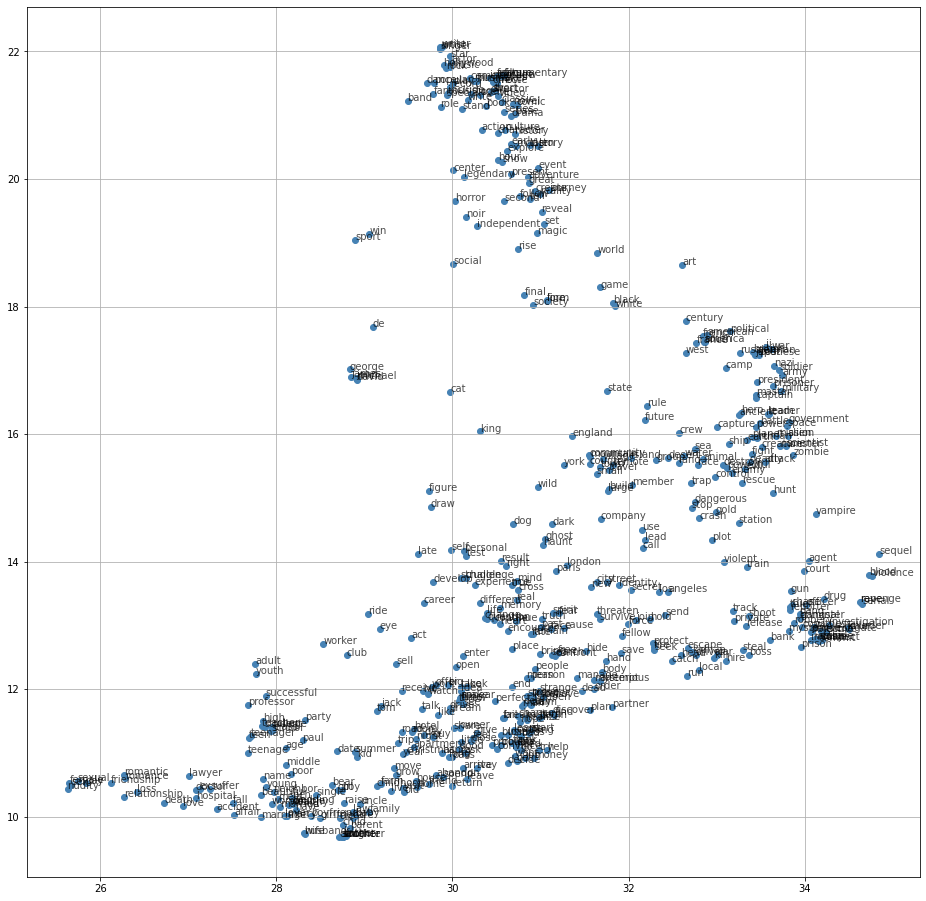

In [42]:
# We plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(wv.key_to_index.keys())[:500])):
    plt.scatter(*model[idx, :], color='steelblue')
    plt.annotate(word, (model[idx, 0], model[idx, 1]), alpha=0.7)
plt.savefig('wv2.png', bbox_inches='tight')
plt.savefig('wv2_2.png')
plt.grid()

In [43]:
def get_vocabulary_coverage(model, gensim_dict):
  coverage = len(model)/len(gensim_dict)
  return coverage

print(get_vocabulary_coverage(wv, D))

0.72040765020982


# Latent Dirichlet Allocation

In [44]:
num_topics = 20

ldag = LdaModel(corpus=reviews_bow, id2word=D, num_topics=num_topics)

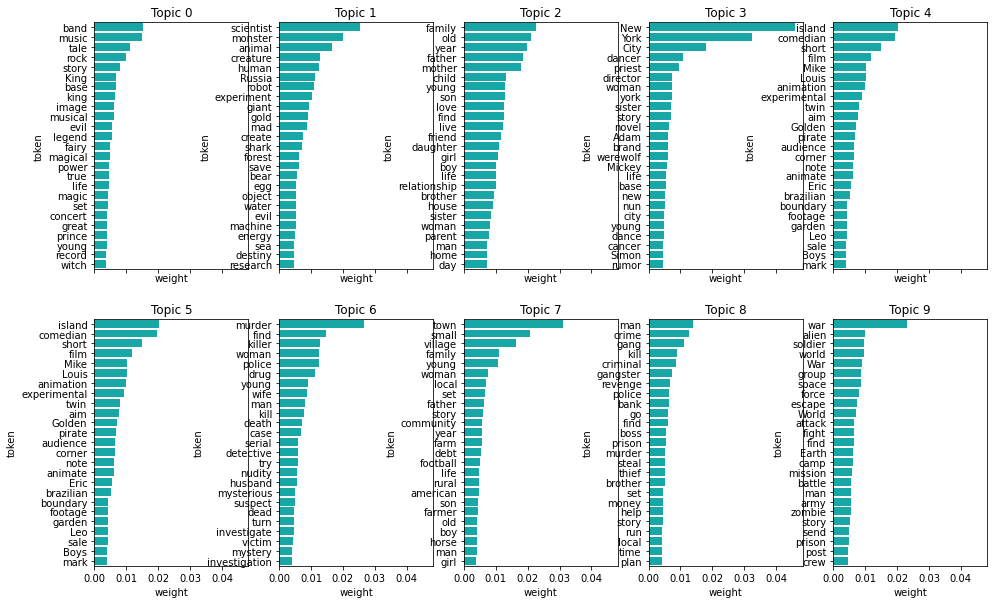

In [45]:
topn = 25

fig, axes = plt.subplots(2, 5, figsize=(16, 10), sharex=True)

for i in range(5):

    tokens, weights = [], []

    for token, weight in ldag.show_topic(i, topn=topn):
        tokens.append(token)
        weights.append(weight)

    df = pd.DataFrame({"token": tokens, "weight": weights})

    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))

    tokens, weights = [], []

    for token, weight in ldag.show_topic(i+4, topn=topn):
        tokens.append(token)
        weights.append(weight)

    df = pd.DataFrame({"token": tokens, "weight": weights})
    
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+5))
    
plt.show()

In [47]:
# having an error with this cell
vis_data = gensimvis.prepare(ldag, reviews_bow, D)
pyLDAvis.display(vis_data)

ValidationError: 
 * Not all rows (distributions) in topic_term_dists sum to 1.